In [38]:
using Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `~/NumericalNavier/MichaelFolder/Notebooks`
Precompiling project...
  ✓ LogExpFunctions → LogExpFunctionsChainRulesCoreExt
  ✓ Clustering
  ✓ ImageMorphology
  ✓ ImageDistances
  ✓ TiffImages
  ✓ ImageFiltering
  ✓ Plots
  ✓ Plots → FileIOExt
  ✓ ImageSegmentation
  ✓ Plots → UnitfulExt
  ✓ ImageCorners
  ✓ Plots → IJuliaExt
  ✓ ImageQualityIndexes
  ✓ Images
  14 dependencies successfully precompiled in 38 seconds. 273 already precompiled.


In [39]:
using IJulia
using LaTeXStrings
using FileIO
using ImageIO
using Images
using Plots
using Base64
using LinearAlgebra
using ImageMagick
using Statistics

In [40]:
function display_image(path)
    image = load(path)
    display(image)
end

function display_gif(path)
    display(MIME("text/html"), """<img src=$path>""")
end

function meshgrid(x, y)
    X = [i for i in x, j in 1:length(y)]
    Y = [j for i in 1:length(x), j in y]
    return X, Y
end

meshgrid (generic function with 1 method)

# Navier Stokes for Numerical Blokes

### The Navier-Stokes equations are partial differential equations which describe the motion of viscous fluid substances, developed from 1822 (Navier) to 1842-1850 (Stokes). 
### These equations have shown to be notoriously hard to solve analytically. Thus, the goal of the project is the following:
1. reformulate the problem into one that can be solved numerically
2. analyze the convergence of the solution
3. analyze its well-possendess
### In this notebook we still focus on the Navier-Stokes equations for incompressible 2D fluid, which are formulated as such:

In [41]:
display_image("images/navier-stokes-2d.png")

ArgumentError: ArgumentError: No file exists at given path: images/navier-stokes-2d.png

### Let us begin by addressing objective 1:The reformulation of the problem into one that can be solved numerically

We choose to solve this problem by using finite-difference-methods (FDM) which are a class of numerical techniquesforsolving differenial equations by approximating derivatvies with finite differences. Both the spatial domain and time domain (if applicable) are discretized, and the values of the solution at the end poins of the intervals are approximated by solving algebraic equations.

To give you a gist of what this means, lets consider the following simple example:
$$
u'(x) = 3u(x) + 2\\
\Rightarrow u(x+h) \approx u(x) + h(3u(x)+2)
$$

The discretization above is known as "forward difference." There are many different discretization schemes and we will analyze the effictiveness of the following on solving our (PDE):
- forward time, backward space
- forward time, center space (Lax-Friedrichs)
- forward time, forward space

To get a feel for how discretization works, we will first focus on Diffusion in 1D, then Burger's Equation in 2D, and then return to our initial (PDE). Burger's equation is a convection-diffusion equation whose analytical solutions are well known (and thus it is easy to calculate the error of our solution).

### In 1D, the diffusion equation reads
$$\frac{\partial u}{\partial t} = \nu \frac{\partial^2 u}{\partial x^2}$$

Discretizing the first partial is trivial, but how can we do so for the second? Consider the Taylor expansion of $u_{i+1}$ and $u_{i-1}$ around $u_i$.

In [42]:
display_image("images/taylor-expansion.png")

ArgumentError: ArgumentError: No file exists at given path: images/taylor-expansion.png

Adding the two, we see that

In [43]:
display_image("images/2nd-partial-discritization.png")

ArgumentError: ArgumentError: No file exists at given path: images/2nd-partial-discritization.png

From here, we obtain

In [44]:
display_image("images/diffusion-1d.png")

ArgumentError: ArgumentError: No file exists at given path: images/diffusion-1d.png

And thus our equation is simply

In [45]:
display_image("images/diffusion-solved.png")

ArgumentError: ArgumentError: No file exists at given path: images/diffusion-solved.png

Given an initial condition, this equation can be solved easily. Let's do so now. For demonstrative purposes (which will be explained later on), we define our initial conditions to be a hat function.

In [52]:
function animate_wave_propagation_diffusion_1d(nx=81, max_nt=100, sigma=.3, nu=0.2)
    dx = 2.0 / (nx-1) # Spatial step size
    dt = sigma*dx^2/nu
    u = ones(nx) # Initial condition, wave at rest

    # Set initial wave pulse
    u[Int(floor(0.5 / dx)) + 1 : Int(floor(1 / dx)) + 1] .= 2
    
    u_values = zeros(max_nt+1, nx) # Matrix to store u values at each time step
    u_values[1, :] = u # Store initial condition

    anim = @animate for nt in 1:max_nt
        un = copy(u) # Copy the current state of u into un
        for i in 2:nx-1 # Iterate over spatial grid points, leaving out the first point for boundary condition
            # Finite difference method for convection equation
            u[i] = un[i] + nu * dt / dx^2 * (un[i+1] - 2 * un[i] + un[i-1])
        end
                
        u_values[nt+1, :] = u # Store u values at each time step

        x = range(0, stop=1, length=nx) # Spatial domain
        plot(x, u, legend=false, ylims=(0, 3)) # Plot current state with fixed y-axis limits
    end
    
    gif(anim, "../../gifs/wave_propagation_diffusion_1d_$nx.gif", fps=30) # Save the animation as a GIF file
                
    return u_values
end

animate_wave_propagation_diffusion_1d (generic function with 5 methods)

In [53]:
u_values = animate_wave_propagation_diffusion_1d();

┌ Info: Saved animation to /Users/michaeltomadakis/NumericalNavier/gifs/wave_propagation_diffusion_1d_81.gif
└ @ Plots /Users/michaeltomadakis/.julia/packages/Plots/ju9dp/src/animation.jl:156


In [55]:
display_gif("../../gifs/wave_propagation_diffusion_1d_81.gif")

Let's look at it again but with a slightly smaller step size.

In [56]:
u_values = animate_wave_propagation_diffusion_1d(31);

┌ Info: Saved animation to /Users/michaeltomadakis/NumericalNavier/gifs/wave_propagation_diffusion_1d_31.gif
└ @ Plots /Users/michaeltomadakis/.julia/packages/Plots/ju9dp/src/animation.jl:156


In [57]:
display_gif("../../gifs/wave_propagation_diffusion_1d_31.gif")

The result is as expected (almost), but I bet you couldn't spot the problem with your naked eye. We will address this issue later on when it becomes more apparent. (Hint: how does step size relate to numerical stability).

The 1D Diffusion Equation is a relatively simple BVP whose solution is somewhat (not really at all tbh but compared to others) straightforward (ask me after class if you really want to know how it's obtained). It's closed form solution can be written as
$$\begin{equation}
u(x, t) = 1 + \sum_{n=1}^{\infty} \left[ \frac{2}{n \pi} \left(\cos\left(\frac{n \pi}{4}\right) - \cos\left(\frac{n \pi}{2}\right) 
\right) \sin\left(\frac{n \pi x}{2}\right)\right] e^{-\left(\frac{n \pi}{2}\right)^2 \nu t}
\end{equation}$$
Let's code it up and see how well we did.

In [58]:
function diffusion_1d_u(x, t, D, n_max)
    u_xt = 1.0
    for n in 1:n_max
        B_n = 2 * (cos(pi * n / 4) - cos(pi * n / 2)) / (pi * n)
        u_xt += B_n * sin(n * pi * x / 2) * exp(-D * (n * pi / 2)^2 * t)
    end
    return u_xt
end

diffusion_1d_u (generic function with 1 method)

Maximum error: 0.500179281114093
Average error: 0.012530598188992189
RMSE: 0.022172727441353953
MAPE: 0.8820982088348815


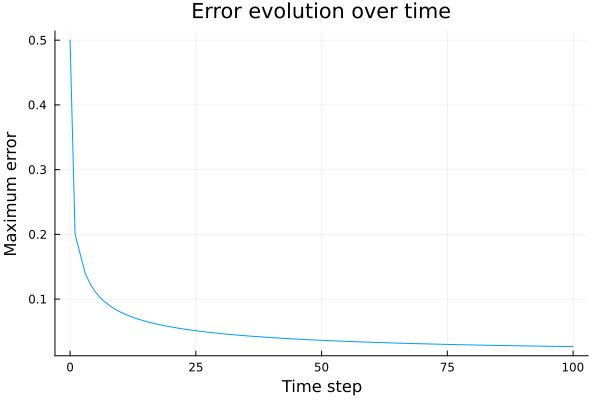

In [59]:
# Simulation parameters
nx = 81
L = 2.0
max_nt = 100
nu = 0.2
sigma = 0.3
n = 50  # Number of Fourier terms
dx = L / (nx - 1)
dt = sigma * dx^2 / nu

# Initial condition
u = ones(nx)
u[Int(floor(0.5 / dx)) + 1 : Int(floor(1 / dx)) + 1] .= 2

# Setup for storing results
u_values = zeros(max_nt+1, nx)
u_values[1, :] = u

# Time stepping
for nt in 1:max_nt
    un = copy(u)
    for i in 2:nx-1
        u[i] = un[i] + nu * dt / dx^2 * (un[i+1] - 2 * un[i] + un[i-1])
    end
    u_values[nt+1, :] = u
end

# Compute the closed-form solution at each time step
x = range(0, stop=L, length=nx)
closed_form_solutions = [diffusion_1d_u(xi, t, nu, n) for t in 0:dt:(max_nt*dt), xi in x]

# Calculate errors
errors = abs.(u_values .- closed_form_solutions)
max_error = maximum(errors)
avg_error = mean(errors)
rmse = sqrt(mean(errors.^2))
mape = mean(abs.(u_values .- closed_form_solutions) ./ closed_form_solutions)*100

# Output error metrics
println("Maximum error: $max_error")
println("Average error: $avg_error")
println("RMSE: $rmse")
println("MAPE: $mape")

# Plotting the error evolution
plot(0:max_nt, maximum(errors, dims=2), xlabel="Time step", ylabel="Maximum error", title="Error evolution over time", legend=false)

Not bad! With only 81 discretization points, we got a MAPE of less than 1%. With more discretization points, it can only go down from here.

There's more! CFL is a condition which must be met for the numerical stability of our simulation. It rquires that our step size remains proportional to our discretization such that the \<property\> which is diffusing does not overstep the bounds of spatially adjacent cells. That is, the timestep is upper bounded. In explicit cases, this bound is usually 1. That is, the "Courant Number", defined as 

$$C = u\frac{dt}{dx} \le1$$

where $u$ represents velocity, is lte to 1. Our discretization is static and challenging to recompute at each step in the simulation, as it would require the lengthening or shortening of various data structures. Our velocity is, however, dynamic in various cases, leading to a Courant number which may vary over the course of the simulation. We can therefore dynamically recompute the timestep size to remain within this bound.

Below is a demonstration on 1D convection:



dx = 1.0 / 40 = 0.025
elapsed_time = 0.011250000000000001
Courant = 0.9
elapsed_time = 0.022500000000000003
Courant = 0.9
elapsed_time = 0.03375
Courant = 0.9
elapsed_time = 0.045000000000000005
Courant = 0.9
elapsed_time = 0.05625000000000001
Courant = 0.9
elapsed_time = 0.0675
Courant = 0.9
elapsed_time = 0.07875
Courant = 0.9
elapsed_time = 0.09
Courant = 0.9
elapsed_time = 0.10124999999999999
Courant = 0.9
elapsed_time = 0.11249999999999999
Courant = 0.9
elapsed_time = 0.12374999999999999
Courant = 0.9
elapsed_time = 0.13500000000236761
Courant = 0.9
elapsed_time = 0.14625000003947036
Courant = 0.9
elapsed_time = 0.15750000036405654
Courant = 0.9
elapsed_time = 0.16875000247291805
Courant = 0.9
elapsed_time = 0.1800000138952206
Courant = 0.9
elapsed_time = 0.1912500687750817
Courant = 0.9
elapsed_time = 0.20250031169103203
Courant = 0.9
elapsed_time = 0.2137513266415551
Courant = 0.9
elapsed_time = 0.22500539049050494
Courant = 0.9
elapsed_time = 0.2362710673614378
Courant = 0.9
el

┌ Info: Saved animation to /Users/michaeltomadakis/NumericalNavier/MichaelFolder/waveOverTime.gif
└ @ Plots /Users/michaeltomadakis/.julia/packages/Plots/ju9dp/src/animation.jl:156


Plots.AnimatedGif("/Users/michaeltomadakis/NumericalNavier/MichaelFolder/waveOverTime.gif")
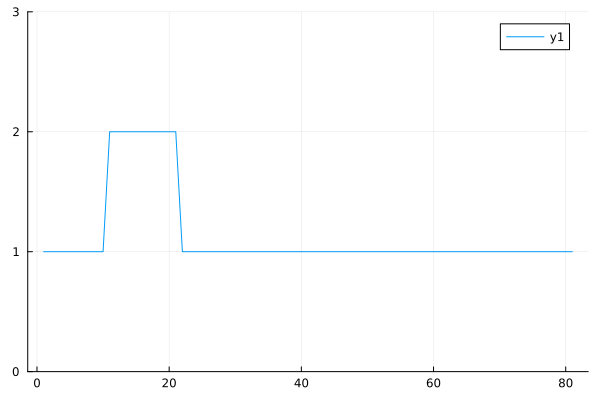

In [87]:
nx = 81             #position step count
@show dx = 1.0 / 40 #space each position step covers
total_time = 1      #1 second of total time
initial_dt = .01
elapsed_time = 0

u = ones(nx)*1
u[11:21].= 2;

anim = @animate while elapsed_time < total_time
    max_u = maximum(u) #find fastest moving <property>
    dt = 0.9 * dx / max_u #max_u/dx <= 1*dt, compute dynamic timestep
    global elapsed_time = dt + elapsed_time
    Courant = max_u*dt/dx 
    @show elapsed_time
    @show Courant
    u2 = copy(u);
    plot(u, ylimit=[0,3])
    for space in 2:nx
        u[space] = u2[space]-u2[space]*dt/dx*(u2[space]-u2[space-1]);
    end
end

gif(anim, "../waveOverTime.gif", fps = 10)

Lets repeat the diffusion experiment above but see if we can obtain better error values or the same error in fewer timesteps using dynamic timestepping, over the same window of real undescretized time!

The courant bound and courant number for diffusion is known to be:
$$C = v\frac{dt}{dx^{2}}\le\frac{1}{2}$$

Since v, or "nu" is constant, this does not need to be dynamically recomputed, maping for a less interesting situation overall. Still, let's see what happens...

total_time = 0.15625000000000003
elapsed_time = 0
Courant = 0.5
Maximum error: 2.004569246031523
Average error: 1.2221701979675559
RMSE: 1.271895368161698
MAPE: 98.04843393414171


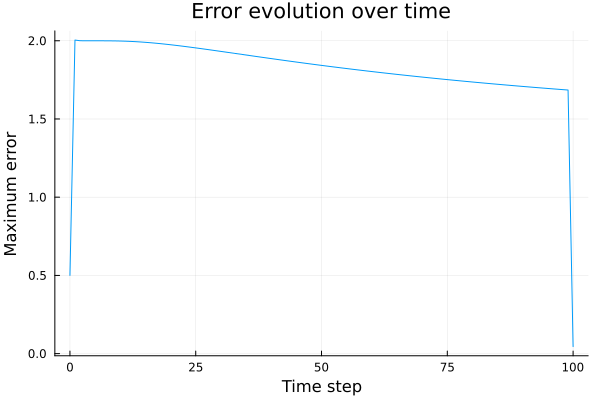

In [117]:
# Simulation parameters
nx = 81
L = 2.0
max_nt = 100
nu = 0.2
nt = 100
sigma = 0.3
n = 50  # Number of Fourier terms
dx = L / (nx - 1)
dt = (dx^2)/(2*nu) #set dt to exactly the max value within CFL
Courant = nu*dt/dx^2 
elapsed_time = 0
total_time = dt*nt
@show total_time
@show elapsed_time
@show Courant

# Initial condition
u = ones(nx)
u[Int(floor(0.5 / dx)) + 1 : Int(floor(1 / dx)) + 1] .= 2

# Setup for storing results
u_values = zeros(max_nt+1, nx)
u_values[1, :] = u

# Compute the closed-form solution at each time step
x = range(0, stop=L, length=nx)

# Time stepping
anim = @animate while elapsed_time < total_time
    global elapsed_time = dt + elapsed_time
    un = copy(u)
    plot(x, [u, diffusion_1d_u.(x, elapsed_time, nu, n)])
    for i in 2:nx-1
        u[i] = un[i] + nu * dt / dx^2 * (un[i+1] - 2 * un[i] + un[i-1])
    end
    u_values[nt+1, :] = u
end



# Calculate errors
errors = abs.(u_values .- closed_form_solutions)
max_error = maximum(errors)
avg_error = mean(errors)
rmse = sqrt(mean(errors.^2))
mape = mean(abs.(u_values .- closed_form_solutions) ./ closed_form_solutions)*100

# Output error metrics
println("Maximum error: $max_error")
println("Average error: $avg_error")
println("RMSE: $rmse")
println("MAPE: $mape")

# Plotting the error evolution
plot(0:max_nt, maximum(errors, dims=2), xlabel="Time step", ylabel="Maximum error", title="Error evolution over time", legend=false)

┌ Info: Saved animation to /Users/michaeltomadakis/NumericalNavier/MichaelFolder/courantDiffusion.gif
└ @ Plots /Users/michaeltomadakis/.julia/packages/Plots/ju9dp/src/animation.jl:156


Plots.AnimatedGif("/Users/michaeltomadakis/NumericalNavier/MichaelFolder/courantDiffusion.gif")
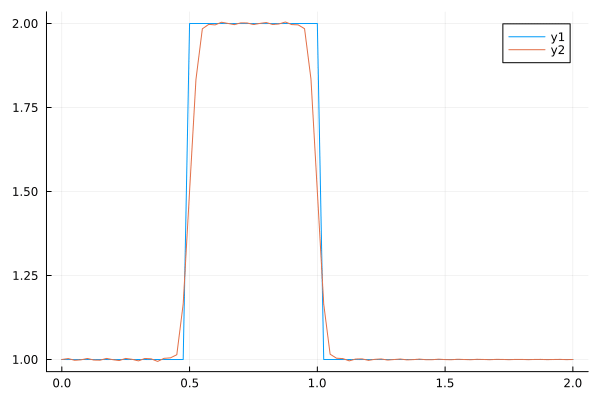

In [118]:
gif(anim, "../courantDiffusion.gif", fps=20)

That's pretty bad. Lots of flickering, likely caused by numerical instability of the CFL being precisely met. Let's instead set dt to 95% of the CFL.

total_time = 0.14062500000000003
elapsed_time = 0
Courant = 0.45000000000000007
Maximum error: 2.004569246031523
Average error: 1.2221827820402076
RMSE: 1.2718953932145434
MAPE: 98.04848744397668


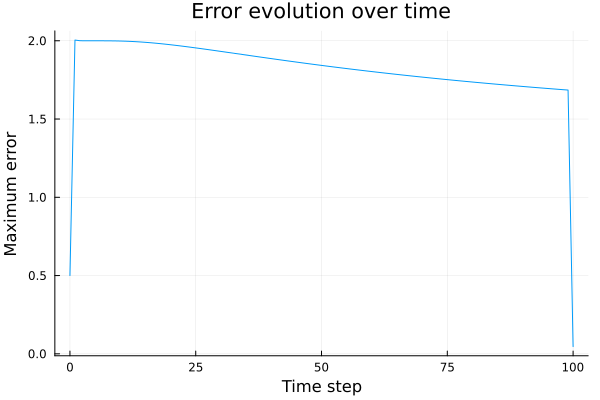

In [119]:
# Simulation parameters
nx = 81
L = 2.0
max_nt = 100
nu = 0.2
nt = 100
sigma = 0.3
n = 50  # Number of Fourier terms
dx = L / (nx - 1)
dt = 0.9(dx^2)/(2*nu) #set dt to exactly the max value within CFL
Courant = nu*dt/dx^2 
elapsed_time = 0
total_time = dt*nt
@show total_time
@show elapsed_time
@show Courant

# Initial condition
u = ones(nx)
u[Int(floor(0.5 / dx)) + 1 : Int(floor(1 / dx)) + 1] .= 2

# Setup for storing results
u_values = zeros(max_nt+1, nx)
u_values[1, :] = u

# Compute the closed-form solution at each time step
x = range(0, stop=L, length=nx)

# Time stepping
anim = @animate while elapsed_time < total_time
    global elapsed_time = dt + elapsed_time
    un = copy(u)
    plot(x, [u, diffusion_1d_u.(x, elapsed_time, nu, n)])
    for i in 2:nx-1
        u[i] = un[i] + nu * dt / dx^2 * (un[i+1] - 2 * un[i] + un[i-1])
    end
    u_values[nt+1, :] = u
end



# Calculate errors
errors = abs.(u_values .- closed_form_solutions)
max_error = maximum(errors)
avg_error = mean(errors)
rmse = sqrt(mean(errors.^2))
mape = mean(abs.(u_values .- closed_form_solutions) ./ closed_form_solutions)*100

# Output error metrics
println("Maximum error: $max_error")
println("Average error: $avg_error")
println("RMSE: $rmse")
println("MAPE: $mape")

# Plotting the error evolution
plot(0:max_nt, maximum(errors, dims=2), xlabel="Time step", ylabel="Maximum error", title="Error evolution over time", legend=false)

┌ Info: Saved animation to /Users/michaeltomadakis/NumericalNavier/MichaelFolder/courantDiffusion90CFL.gif
└ @ Plots /Users/michaeltomadakis/.julia/packages/Plots/ju9dp/src/animation.jl:156


Plots.AnimatedGif("/Users/michaeltomadakis/NumericalNavier/MichaelFolder/courantDiffusion90CFL.gif")
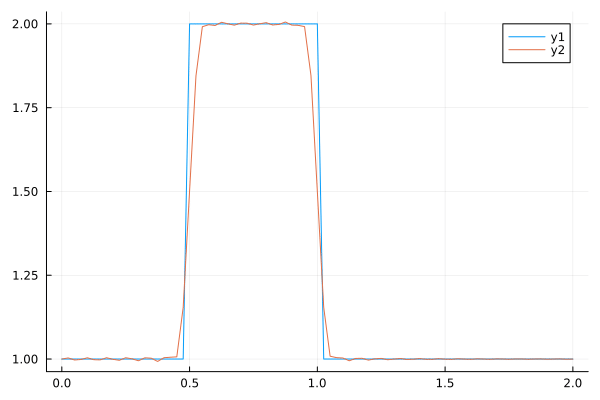

In [120]:
gif(anim, "../courantDiffusion90CFL.gif", fps=20)
#much better. Still bad, but much better...

### Let's move on to Burger's Equation

In 2D, Burger's Equation reads
$$
\frac{\partial u}{\partial t} + u\frac{\partial u}{\partial x} + v\frac{\partial u}{\partial y} = \nu \left( \frac{\partial^2 u}{\partial x^2} + \frac{\partial^2 u}{\partial y^2} \right)
$$
$$
\frac{\partial v}{\partial t} + u\frac{\partial v}{\partial x} + v\frac{\partial v}{\partial y} = \nu \left( \frac{\partial^2 v}{\partial x^2} + \frac{\partial^2 v}{\partial y^2} \right)
$$

As before, we discretize each term obtaining

In [19]:
display_image("images/burgers-discretized.png")

UndefVarError: UndefVarError: `load` not defined

Solving for our unknowns,

In [20]:
display_image("images/burgers-solved.png")

UndefVarError: UndefVarError: `load` not defined

Time to code it up.

# Burgers needs to be encapsulated

In [21]:
###variable declarations
nx = 41
ny = 41
nt = 120
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
sigma = .0009
nu = .001
dt = sigma * dx * dy / nu


x = 0:dx:2
y = 0:dy:2

u = ones(ny, nx)  # create a 1xn vector of 1's
v = ones(ny, nx)
un = ones(ny, nx) 
vn = ones(ny, nx)

###Assign initial conditions

##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
u[Int(.5 / dy):Int(1 / dy + 1),Int(.5 / dx):Int(1 / dx + 1)] .= 2;
##set hat function I.C. : u(.5<=x<=1 && .5<=y<=1 ) is 2
v[Int(.5 / dy):Int(1 / dy + 1),Int(.5 / dx):Int(1 / dx + 1)] .= 2;

In [22]:
heatmap(x, y, u, color=cgrad([:lightblue,:white,:red]), clim=(1,2))

UndefVarError: UndefVarError: `cgrad` not defined

In [23]:
heatmap(x, y, v, color=cgrad([:lightblue,:white,:red]), clim=(1,2))

UndefVarError: UndefVarError: `cgrad` not defined

In [24]:
anim = @animate for n in 1:nt+1
    un = copy(u)
    vn = copy(v)
    
    u[2:end-1, 2:end-1] .= (un[2:end-1, 2:end-1] -
        dt / dx .* un[2:end-1, 2:end-1] .* 
        (un[2:end-1, 2:end-1] .- un[2:end-1, 1:end-2]) - 
        dt / dy .* vn[2:end-1, 2:end-1] .* 
        (un[2:end-1, 2:end-1] .- un[1:end-2, 2:end-1]) + 
        nu * dt / dx^2 .* 
        (un[2:end-1,3:end] - 2 .* un[2:end-1, 2:end-1] .+ un[2:end-1, 1:end-2]) + 
        nu * dt / dy^2 .* 
        (un[3:end, 2:end-1] - 2 .* un[2:end-1, 2:end-1] .+ un[1:end-2, 2:end-1]))

    v[2:end-1, 2:end-1] .= (vn[2:end-1, 2:end-1] - 
        dt / dx .* un[2:end-1, 2:end-1] .*
        (vn[2:end-1, 2:end-1] .- vn[2:end-1, 1:end-2]) -
        dt / dy .* vn[2:end-1, 2:end-1] .* 
        (vn[2:end-1, 2:end-1] .- vn[1:end-2, 2:end-1]) + 
        nu * dt / dx^2 .* 
        (vn[2:end-1, 3:end] - 2 .* vn[2:end-1, 2:end-1] .+ vn[2:end-1, 1:end-2]) +
        nu * dt / dy^2 .*
        (vn[3:end, 2:end-1] - 2 .* vn[2:end-1, 2:end-1] .+ vn[1:end-2, 2:end-1]))
     
    u[1, :] .= 1
    u[end, :] .= 1
    u[:, 1] .= 1
    u[:, end] .= 1
    
    v[1, :] .= 1
    v[end, :] .= 1
    v[:, 1] .= 1
    v[:, end] .= 1

    heatmap(x, y, u, color=cgrad([:lightblue,:white,:red]), clim=(1,2))
    #plot(x, y, u, st=:surface, color=cgrad([:black,:white]), zlimits=[0.99, 2.01])
end

gif(anim, "gifs/burgers_2d.gif", fps = 60)


LoadError: LoadError: UndefVarError: `@animate` not defined
in expression starting at /Users/michaeltomadakis/NumericalNavier/MichaelFolder/Notebooks/Final-Notebook-Testbed.ipynb:1

As before, lets compare with the known closed form solution.
$$\alpha = \frac{1}{4 \nu t}, \quad \beta = -\frac{1}{4 \nu}$$
$$u(x, y, t, \nu) = v(x, y, t, \nu) = \frac{1 + \exp\left(\beta (x + y - t)\right)}{1 + \exp\left(\beta (x + y - t)\right) + \exp\left(\alpha (x^2 + y^2)\right)}
$$

In [25]:
# True solution
function burgers_closed_form(x, y, t, ν)
    α = 1 / (4 * ν * t)
    β = -1 / (4 * ν)
    u_true = @. (1 + exp(β * (x + y - t))) / (1 + exp(β * (x + y - t)) + exp(α * (x^2 + y^2)))
    v_true = @. (1 + exp(β * (x + y - t))) / (1 + exp(β * (x + y - t)) + exp(α * (x^2 + y^2)))
    return u_true, v_true
end

# Error analysis
err_u = zeros(ny, nx)
err_v = zeros(ny, nx)

# Create gif
@gif for n in 1:nt+1
    t = (n - 1) * dt
    
    for i in 1:ny
        for j in 1:nx
            u_true, v_true = burgers_closed_form(x[j], y[i], t, nu)
            err_u[i, j] = abs(u[i, j] - u_true)
            err_v[i, j] = abs(v[i, j] - v_true)
        end
    end
    
    p1 = heatmap(x, y, err_u', title="Error in u at t = $(round(t, digits=2))", xlabel="x", ylabel="y", color=:viridis, clim=(0, maximum(err_u)))
    p2 = heatmap(x, y, err_v', title="Error in v at t = $(round(t, digits=2))", xlabel="x", ylabel="y", color=:viridis, clim=(0, maximum(err_v)))
    
    plot(p1, p2, layout=(1, 2), size=(800, 400))
end

LoadError: LoadError: UndefVarError: `@gif` not defined
in expression starting at /Users/michaeltomadakis/NumericalNavier/MichaelFolder/Notebooks/Final-Notebook-Testbed.ipynb:15

### Finally, we are equipped to take on our original (PDE)

Recall what our equations are:

In [26]:
display_image("images/navier-stokes.png")

UndefVarError: UndefVarError: `load` not defined

We discretize as usual:

In [27]:
display_image("images/navier-stokes-discrete.png")

UndefVarError: UndefVarError: `load` not defined

Rearranging to get the explicit form we want,

In [28]:
display_image("images/navier-stokes-solved.png")

UndefVarError: UndefVarError: `load` not defined

### need to actually code it up now + do error analysis to online julia pkg solvers. also this error analysis is pretty basic bc its all explicit  so ig we should do some implicit, that way we can compare lu to qr or whatnot.
### Link: https://nbviewer.org/github/barbagroup/CFDPython/blob/master/lessons/15_Step_12.ipynb

what needs to be done
- as mentioned above
- implement the 3 I covered with adaptive steps to demonstrate changes in error if cfl is met vs if it is not met (this should not be hard at all, probably 3 lines of code needto be changed max)
- somewhere in here we should introduce the concept of cfl, maybe give a sketch of a proof is we're feeling goofy

# ...

In [29]:
function build_up_b(rho, dt, dx, dy, u, v)
    b = zeros(size(u))
    b[2:end-1, 2:end-1] .= (rho * (1 / dt * ((u[2:end-1, 3:end] - u[2:end-1, 1:end-2]) / (2 * dx) +
                                            (v[3:end, 2:end-1] - v[1:end-2, 2:end-1]) / (2 * dy)) -
                                      ((u[2:end-1, 3:end] - u[2:end-1, 1:end-2]) / (2 * dx)).^2 -
                                      2 * ((u[3:end, 2:end-1] - u[1:end-2, 2:end-1]) / (2 * dy) .* 
                                           (v[2:end-1, 3:end] - v[2:end-1, 1:end-2]) / (2 * dx)) -
                                      ((v[3:end, 2:end-1] - v[1:end-2, 2:end-1]) / (2 * dy)).^2))

    # Periodic BC Pressure @ x = 2
    b[2:end-1, end] .= (rho * (1 / dt * ((u[2:end-1, 1] - u[2:end-1, end-1]) / (2 * dx) +
                                         (v[3:end, end] - v[1:end-2, end]) / (2 * dy)) -
                               ((u[2:end-1, 1] - u[2:end-1, end-1]) / (2 * dx)).^2 -
                               2 * ((u[3:end, end] - u[1:end-2, end]) / (2 * dy) .*
                                    (v[2:end-1, 1] - v[2:end-1, end-1]) / (2 * dx)) -
                               ((v[3:end, end] - v[1:end-2, end]) / (2 * dy)).^2))

    # Periodic BC Pressure @ x = 0
    b[2:end-1, 1] .= (rho * (1 / dt * ((u[2:end-1, 2] - u[2:end-1, end]) / (2 * dx) +
                                       (v[3:end, 1] - v[1:end-2, 1]) / (2 * dy)) -
                             ((u[2:end-1, 2] - u[2:end-1, end]) / (2 * dx)).^2 -
                             2 * ((u[3:end, 1] - u[1:end-2, 1]) / (2 * dy) .*
                                  (v[2:end-1, 2] - v[2:end-1, end]) / (2 * dx)) -
                             ((v[3:end, 1] - v[1:end-2, 1]) / (2 * dy)).^2))

    return b
end

function pressure_poisson_periodic(p, dx, dy, b, nit)
    for q in 1:nit
        pn = copy(p)
        p[2:end-1, 2:end-1] .= ((pn[2:end-1, 3:end] + pn[2:end-1, 1:end-2]) * dy^2 +
                                (pn[3:end, 2:end-1] + pn[1:end-2, 2:end-1]) * dx^2) /
                               (2 * (dx^2 + dy^2)) -
                               dx^2 * dy^2 / (2 * (dx^2 + dy^2)) * b[2:end-1, 2:end-1]

        # Periodic BC Pressure @ x = 2
        p[2:end-1, end] .= ((pn[2:end-1, 1] + pn[2:end-1, end-1]) * dy^2 +
                            (pn[3:end, end] + pn[1:end-2, end]) * dx^2) /
                           (2 * (dx^2 + dy^2)) -
                           dx^2 * dy^2 / (2 * (dx^2 + dy^2)) * b[2:end-1, end]

        # Periodic BC Pressure @ x = 0
        p[2:end-1, 1] .= ((pn[2:end-1, 2] + pn[2:end-1, end]) * dy^2 +
                          (pn[3:end, 1] + pn[1:end-2, 1]) * dx^2) /
                         (2 * (dx^2 + dy^2)) -
                         dx^2 * dy^2 / (2 * (dx^2 + dy^2)) * b[2:end-1, 1]

        # Wall boundary conditions, pressure
        p[end, :] .= p[end-1, :]  # dp/dy = 0 at y = 2
        p[1, :] .= p[2, :]  # dp/dy = 0 at y = 0
    end

    return p
end

pressure_poisson_periodic (generic function with 1 method)

In [30]:
nx = 41
ny = 41
nt = 10
nit = 50 
c = 1
dx = 2 / (nx - 1)
dy = 2 / (ny - 1)
x = LinRange(0, 2, nx)
y = LinRange(0, 2, ny)

X, Y = Matlab.meshgrid(x,y)

##physical variables
rho = 1
nu = .1
F = 1
dt = .01

#initial conditions
u = zeros(ny, nx)
un = zeros(ny, nx)

v = zeros(ny, nx)
vn = zeros(ny, nx)

p = ones(ny, nx)
pn = ones(ny, nx)

b = zeros(ny, nx);

UndefVarError: UndefVarError: `Matlab` not defined

In [31]:
function calculate_cfl(u, v, dt, dx, dy)
    u_max = maximum(abs.(u))
    v_max = maximum(abs.(v))

    cfl = (u_max * dt / dx) + (v_max * dt / dy)

    return cfl
end

calculate_cfl (generic function with 1 method)

In [32]:
udiff = 1.0
stepcount = 0
max_cfl = 0.5

while udiff > 0.001
    un = copy(u)
    vn = copy(v)

    b = build_up_b(rho, dt, dx, dy, u, v)
    p = pressure_poisson_periodic(p, dx, dy, b, nit)

    u[2:end-1, 2:end-1] .= un[2:end-1, 2:end-1] .-
                          un[2:end-1, 2:end-1] .* dt / dx .* 
                          (un[2:end-1, 2:end-1] - un[2:end-1, 1:end-2]) .-
                          vn[2:end-1, 2:end-1] .* dt / dy .* 
                          (un[2:end-1, 2:end-1] - un[1:end-2, 2:end-1]) .-
                          dt / (2 * rho * dx) .* 
                          (p[2:end-1, 3:end] - p[2:end-1, 1:end-2]) .+
                          nu * (dt / (dx^2) * 
                          (un[2:end-1, 3:end] - 2 .* un[2:end-1, 2:end-1] + un[2:end-1, 1:end-2]) .+
                          dt / (dy^2) * 
                          (un[3:end, 2:end-1] - 2 .* un[2:end-1, 2:end-1] + un[1:end-2, 2:end-1])) .+
                          F * dt

    v[2:end-1, 2:end-1] .= vn[2:end-1, 2:end-1] .-
                          un[2:end-1, 2:end-1] .* dt / dx .* 
                          (vn[2:end-1, 2:end-1] - vn[2:end-1, 1:end-2]) .-
                          vn[2:end-1, 2:end-1] .* dt / dy .* 
                          (vn[2:end-1, 2:end-1] - vn[1:end-2, 2:end-1]) .-
                          dt / (2 * rho * dy) .* 
                          (p[3:end, 2:end-1] - p[1:end-2, 2:end-1]) .+
                          nu * (dt / (dx^2) *
                          (vn[2:end-1, 3:end] - 2 .* vn[2:end-1, 2:end-1] + vn[2:end-1, 1:end-2]) .+
                          dt / (dy^2) *
                          (vn[3:end, 2:end-1] - 2 .* vn[2:end-1, 2:end-1] + vn[1:end-2, 2:end-1]))

    u[1, :] .= 0
    u[end, :] .= 0
    v[1, :] .= 0
    v[end, :] .= 0

    udiff = abs.(sum(u) - sum(un)) / sum(u)
    stepcount += 1

    cfl = calculate_cfl(u, v, dt, dx, dy)
    if cfl > max_cfl
        println("CFL number is too large: $cfl.")
        break
    end
end


UndefVarError: UndefVarError: `rho` not defined

In [33]:
quiver(X[1:3:end, 1:3:end], Y[1:3:end, 1:3:end], quiver=(u[1:3:end, 1:3:end], v[1:3:end, 1:3:end]))

UndefVarError: UndefVarError: `X` not defined

Now that we have obtained a numerical approximation to our solution, and are satisfied with our "error", lets discuss project objectives 2 & 3. Note that we put "error" in quotation marks because we are yet to prove that our solution converges as we further refine our discretization. The "closed-form" solutions we compared to are numerical approximations obtained from well known julia packages. However, if we cannot prove convergence, who's to say their numerical approximation is any better than ours. Additionally, let's say that we do converge to something, how do we know that we are converging to an approximation of the closed form solution?

## Convergence and Well-possedness

A numerical method is said to be *consistent* is the discretization errors induced by the method decrease to zero as the discretization parameters approach 0. In the context of the local truncation error, we require
$$\lim_{\Delta t, \Delta x \to 0}LTE = 0$$
Checking that this condition holds rigourosly can sometimes be challenging, Lagrange Remainder Theorem can help.

Conceptually, *stability* means that the numerical errors do not grow uncontrollably as the computation advances in time (CFL helps but is not enough).

Why are both needed? 
- Consistency without stability might mean accurately representing the differential equation, but small errors could grow exponentially, leading to useless results. 
- Stability without consistency might control error growth well, but the errors might not necessarily diminish with finer discretizations, potentially leading to a stable but inaccurate solution

**Lax-Richtmyer equivalence theorem:** For a consistent finite difference method for a well-posed linear initial value problem, the method is convergent if and only if it is stable.

Stuff becomes harder to prove when we get to BVPs and introduce nonlinearity.